In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle
from pathlib import Path
from importlib import reload
from IPython.display import clear_output

from IEFC_modules import iefc_functions

import roman
import iefc_simulation as iefc
import misc

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')

wavelength_c = 575e-9*u.m

wavelength_ref = 0.5e-6*u.m
pixelscale_lamD_ref = 1/2
pixelscale_ref = 13e-6*u.m/u.pix
pixelscale_lamD = pixelscale_lamD_ref * (wavelength_ref/wavelength_c)
print(pixelscale_lamD)

wavelength = 575e-9*u.m
npsf = 64
psf_pixelscale = 13e-6*u.m/u.pix
# npsf = 256
# psf_pixelscale = 2.9587987694e-6*u.m/u.pix
psf_pixelscale_lamD = pixelscale_lamD * (psf_pixelscale/pixelscale_ref)
print(psf_pixelscale_lamD)

Nact = 48
dm_diam = 46.3*u.mm
act_spacing = 0.9906*u.mm


0.43478260869565216
0.43478260869565216


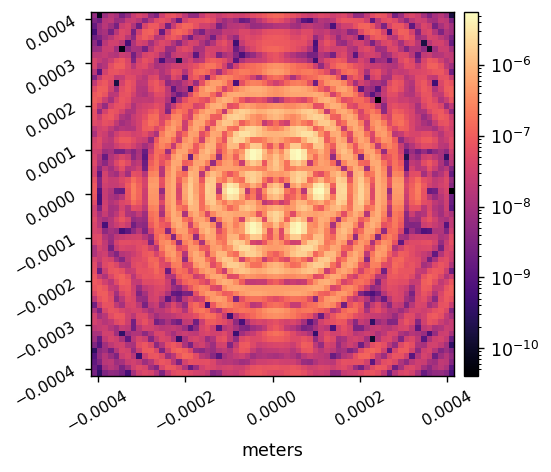

In [2]:
reload(roman)

hlci = roman.CGI(use_opds=False, quiet=True)
psf = hlci.calc_psf()

misc.myimshow(psf, lognorm=True, pxscl=hlci.psf_pixelscale)

# Create dark hole ROI to calibrate and control

In [11]:
weights

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

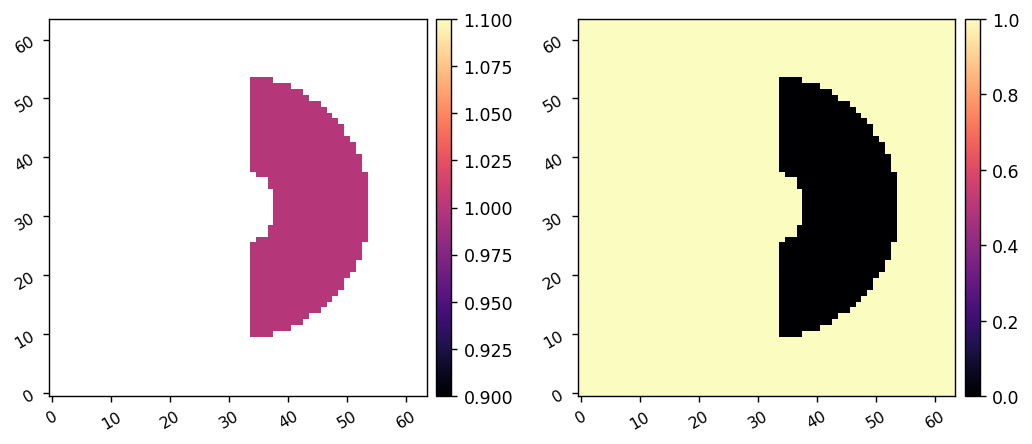

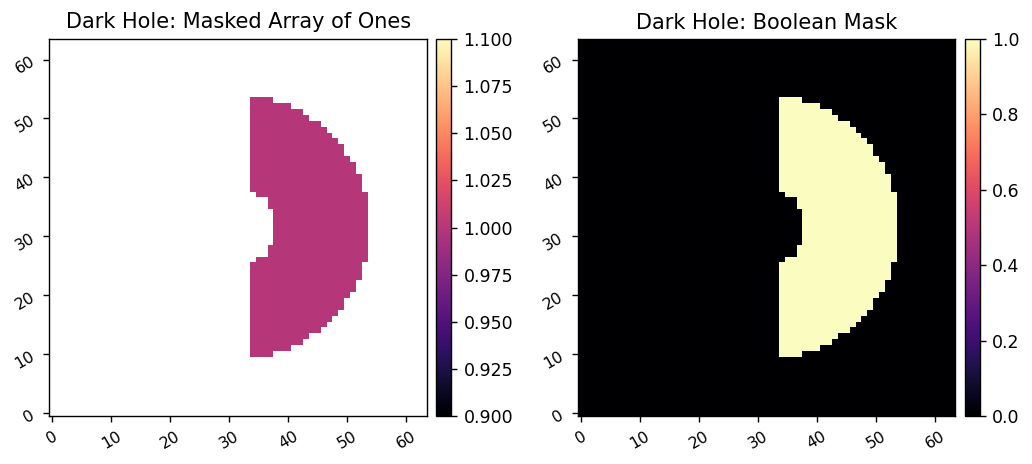

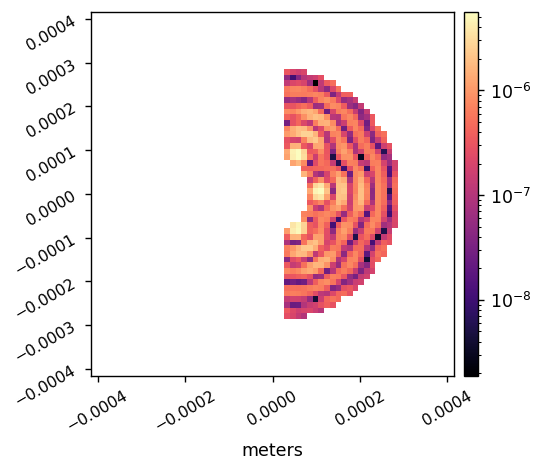

In [3]:
# set dark hole ROI (only annular dark-holes supported for now)
iwa = 2.8*psf_pixelscale/psf_pixelscale_lamD
owa = 9.7*psf_pixelscale/psf_pixelscale_lamD
roi_side = 'right'
roi_offset = 1*psf_pixelscale/psf_pixelscale_lamD

roi_mask = misc.create_annular_roi_mask(npsf, psf_pixelscale, iwa, owa, side=roi_side, offset=roi_offset)

relative_weight = 0.99
weights = roi_mask * relative_weight + (1 - relative_weight) * roi_mask

misc.myimshow2(weights, weights.mask)
misc.myimshow2(roi_mask, ~roi_mask.mask, 'Dark Hole: Masked Array of Ones', 'Dark Hole: Boolean Mask')
misc.myimshow(psf*roi_mask, lognorm=True, pxscl=hlci.psf_pixelscale)

# Create probe and fourier modes

Creating Fourier modes:  (64, 64)
(300, 2304) (2, 2304)


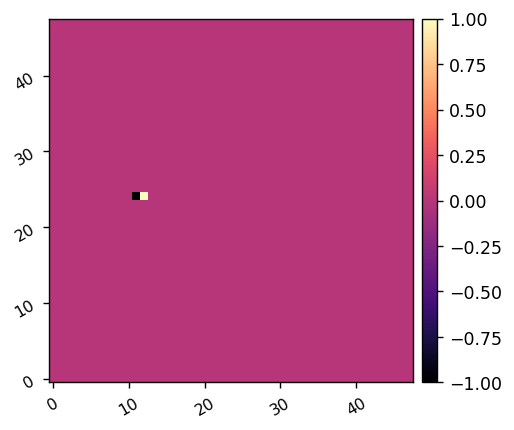

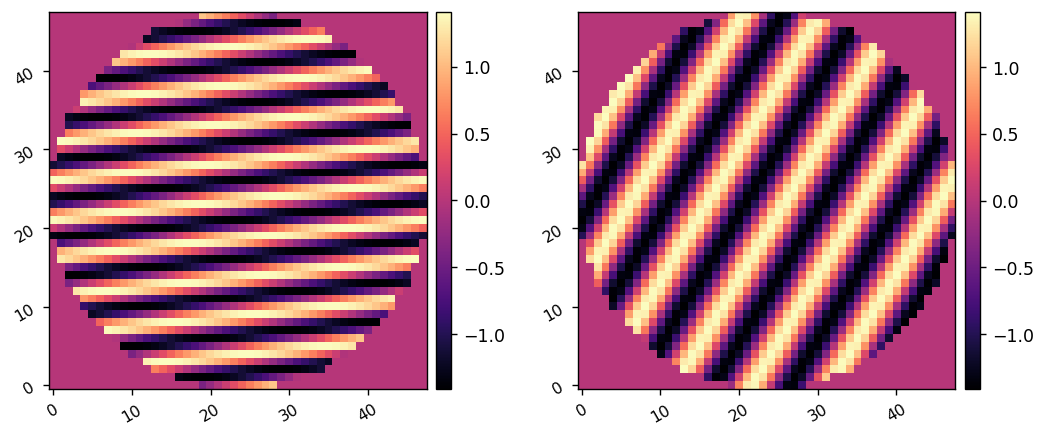

In [35]:
reload(iefc)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

fourier_modes, fx, fy = iefc.create_fourier_modes(xfp, ~roi_mask.mask, Nact=Nact, circular_mask=True)
probe_modes = iefc.create_probe_poke_modes(Nact, Nact//4, Nact//2, Nact//4-1, Nact//2)

# calibration_mask = misc.create_annular_roi_mask(npsf, psf_pixelscale, )

probe_amplitude = 0.05 * wavelength.to(u.m).value
calibration_amplitude = 0.006 * wavelength.to(u.m).value

print(fourier_modes.shape, probe_modes.shape)
misc.myimshow((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)))
misc.myimshow2(fourier_modes[0].reshape((Nact,Nact)), fourier_modes[200].reshape((Nact,Nact)))

In [34]:
for mode in fourier_modes:
    print(np.sum(mode))

-1.41390702449212
1.4139070244921323
1.413907024492155
-1.4139070244921572
1.4139070244920546
-1.4139070244921024
1.4139070244921665
-1.4139070244921825
1.4139070244921632
-1.4139070244921301
1.4139070244921426
-1.4139070244921754
1.4139070244922003
1.4139070244922016
-1.4139070244922014
1.4139070244922185
-1.4139070244922711
1.4139070244922105
-1.4139070244922234
1.4139070244920418
-1.413907024492131
1.4139070244921519
-1.4139070244921017
1.4139070244921206
-1.4139070244921355
1.4139070244923264
-1.413907024492214
1.4139070244921956
1.4139070244921688
-1.413907024492143
1.4139070244922287
-1.4139070244921883
1.4139070244923064
-1.4139070244921133
1.4139070244922025
-1.4139070244921799
1.413907024492158
-1.4139070244921914
1.4139070244921692
-1.4139070244921372
1.4139070244920324
-1.4139070244921852
1.413907024492124
-1.413907024492278
1.413907024492144
-1.4139070244921048
1.4139070244921674
-1.4139070244921759
1.413907024492199
-1.4139070244921381
1.4139070244922314
-1.413907024492081

(2, 4096) (4, 4096)


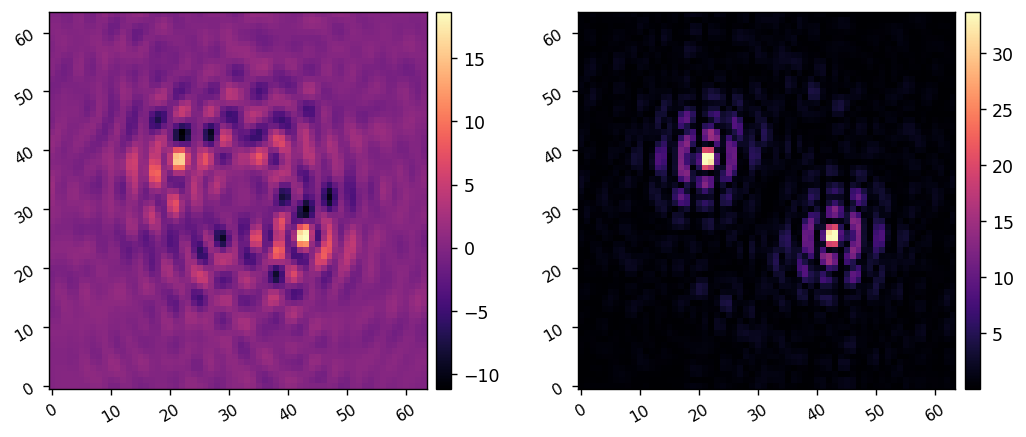

In [22]:
reload(roman)

hlci.set_dm1(-calibration_amplitude * fourier_modes[200])
misc.display_dm(hlci.DM1, vmax=1e-8)
differential_images, single_images = iefc.take_measurement(hlci, probe_modes, probe_amplitude, return_all=True)

hlci.set_dm1(calibration_amplitude * fourier_modes[200])
misc.display_dm(hlci.DM1, vmax=1e-8)
differential_images_2, single_images_2 = iefc.take_measurement(hlci, probe_modes, probe_amplitude, return_all=True)

print(differential_images.shape, single_images.shape)
misc.myimshow2(differential_images[1].reshape((64,64)), 
               abs(differential_images[1].reshape((64,64))-differential_images_2[1].reshape((64,64))))

# Calibrate IEFC (or load in previous calibration data)

In [23]:
reload(iefc)

# hlci = roman.CGI(cgi_mode='hlc')
response_cube, calibration_cube = iefc.calibrate(hlci, probe_amplitude, probe_modes, 
                                                 calibration_amplitude, fourier_modes, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 300 in 18.444s
	Calibrated mode 2 / 300 in 35.850s
	Calibrated mode 3 / 300 in 53.480s
	Calibrated mode 4 / 300 in 71.778s
	Calibrated mode 5 / 300 in 89.185s
	Calibrated mode 6 / 300 in 106.850s
	Calibrated mode 7 / 300 in 124.216s
	Calibrated mode 8 / 300 in 142.890s
	Calibrated mode 9 / 300 in 160.400s
	Calibrated mode 10 / 300 in 177.808s
	Calibrated mode 11 / 300 in 195.867s
	Calibrated mode 12 / 300 in 213.277s
	Calibrated mode 13 / 300 in 230.668s
	Calibrated mode 14 / 300 in 248.060s
	Calibrated mode 15 / 300 in 266.200s
	Calibrated mode 16 / 300 in 283.660s
	Calibrated mode 17 / 300 in 301.266s
	Calibrated mode 18 / 300 in 319.563s
	Calibrated mode 19 / 300 in 337.052s
	Calibrated mode 20 / 300 in 354.533s
	Calibrated mode 21 / 300 in 372.084s
	Calibrated mode 22 / 300 in 390.358s
	Calibrated mode 23 / 300 in 407.724s
	Calibrated mode 24 / 300 in 425.262s
	Calibrated mode 25 / 300 in 443.533s
	Calibrated mode 26 / 300 in 461.238s
	Cali

	Calibrated mode 210 / 300 in 3728.646s
	Calibrated mode 211 / 300 in 3747.217s
	Calibrated mode 212 / 300 in 3764.819s
	Calibrated mode 213 / 300 in 3782.407s
	Calibrated mode 214 / 300 in 3801.280s
	Calibrated mode 215 / 300 in 3819.324s
	Calibrated mode 216 / 300 in 3836.894s
	Calibrated mode 217 / 300 in 3854.394s
	Calibrated mode 218 / 300 in 3872.824s
	Calibrated mode 219 / 300 in 3890.520s
	Calibrated mode 220 / 300 in 3907.990s
	Calibrated mode 221 / 300 in 3926.185s
	Calibrated mode 222 / 300 in 3943.978s
	Calibrated mode 223 / 300 in 3961.649s
	Calibrated mode 224 / 300 in 3979.243s
	Calibrated mode 225 / 300 in 3997.872s
	Calibrated mode 226 / 300 in 4015.634s
	Calibrated mode 227 / 300 in 4033.186s
	Calibrated mode 228 / 300 in 4052.012s
	Calibrated mode 229 / 300 in 4069.759s
	Calibrated mode 230 / 300 in 4087.320s
	Calibrated mode 231 / 300 in 4104.940s
	Calibrated mode 232 / 300 in 4124.002s
	Calibrated mode 233 / 300 in 4141.544s
	Calibrated mode 234 / 300 in 4159.090s


In [24]:
print(response_cube.shape, calibration_cube.shape)

response_hdu = fits.PrimaryHDU(data=response_cube)
response_hdu.writeto(data_dir/'response-data'/'hlc_response_cube_ann_mask.fits', overwrite=True)

calib_hdu = fits.PrimaryHDU(data=calibration_cube)
calib_hdu.writeto(data_dir/'calibration-data'/'hlc_calibration_cube_ann_mask.fits', overwrite=True)

(300, 2, 4096) (600, 4, 4096)


In [4]:
response_cube = fits.getdata(data_dir/'response-data'/'hlc_response_cube_ann_mask.fits')
calibration_cube = fits.getdata(data_dir/'calibration-data'/'hlc_calibration_cube_ann_mask.fits')
print(response_cube.shape, calibration_cube.shape)

(300, 2, 4096) (600, 4, 4096)


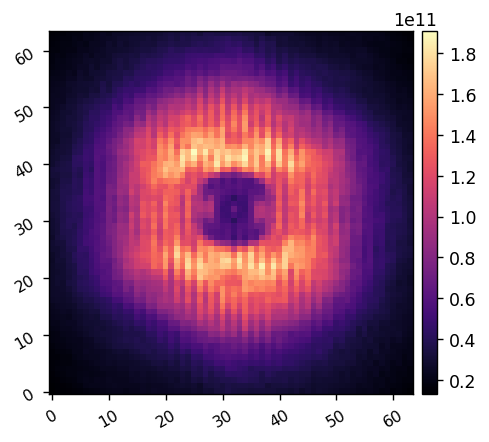

In [5]:
im = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(im.reshape(64,64))

# Filter calibration data (optional but unnecessary for static systems/simulations.

In [11]:
# Filter the calibration files by subtracting PCA modes
npca = 3
filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

# Create control matrix

In [6]:
# control_matrix = iefc.construct_control_matrix(response_cube, 
#                                                weights.flatten(), rcond=5e-2, pca_modes=None)
control_matrix = iefc.construct_control_matrix(response_cube, 
                                               weights.flatten(), rcond=5e-2, pca_modes=None)


# Run IEFC

Closed-loop iteration 1 / 10
(2304,) (300,)


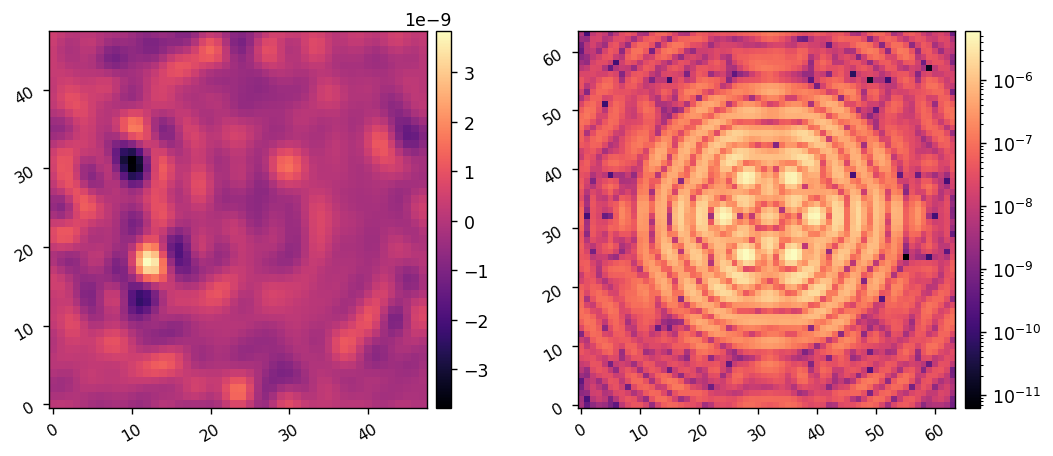

Closed-loop iteration 2 / 10
(2304,) (300,)


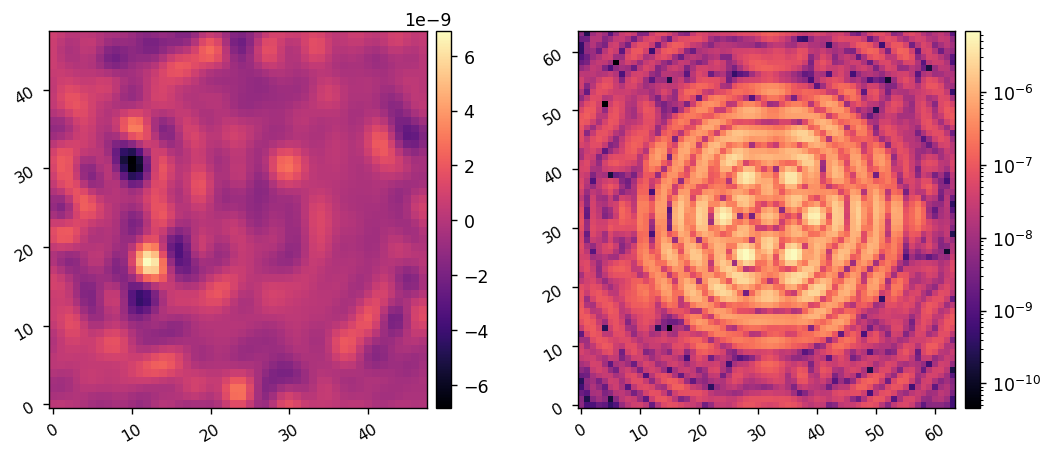

Closed-loop iteration 3 / 10
(2304,) (300,)


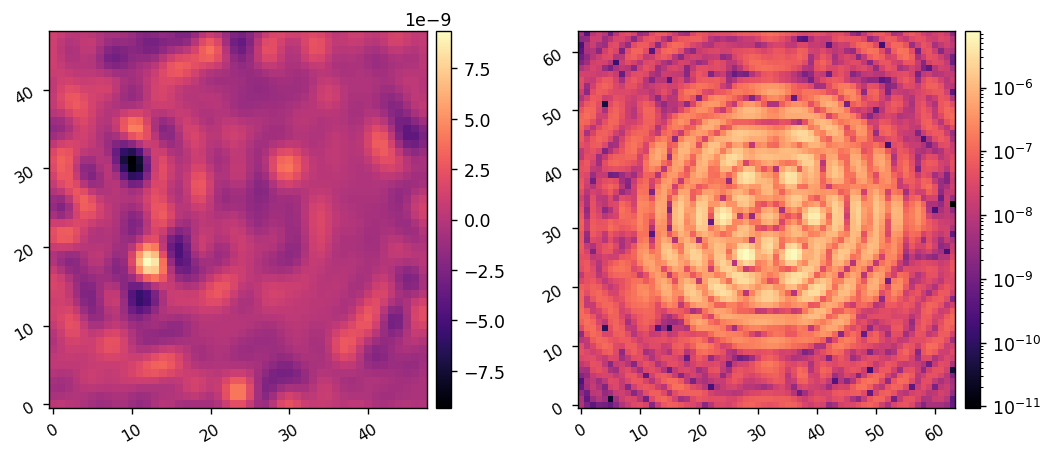

Closed-loop iteration 4 / 10
(2304,) (300,)


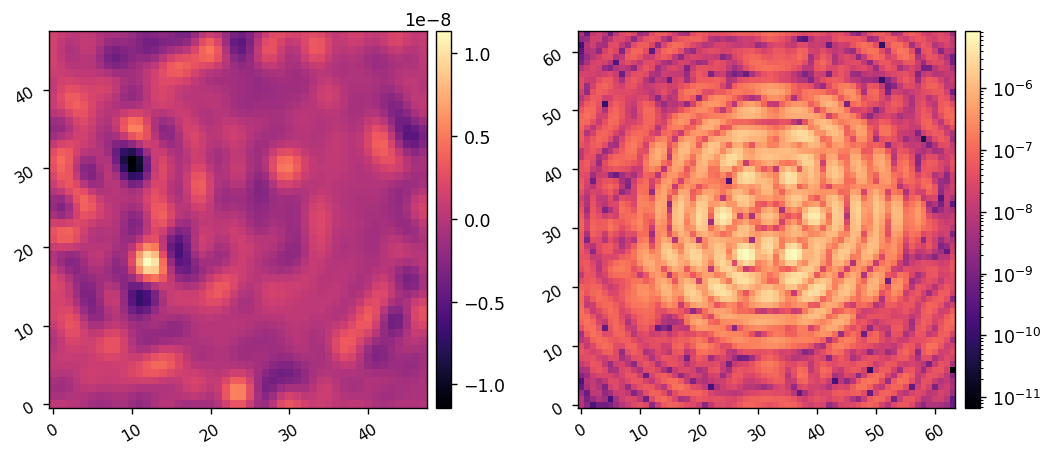

Closed-loop iteration 5 / 10
(2304,) (300,)


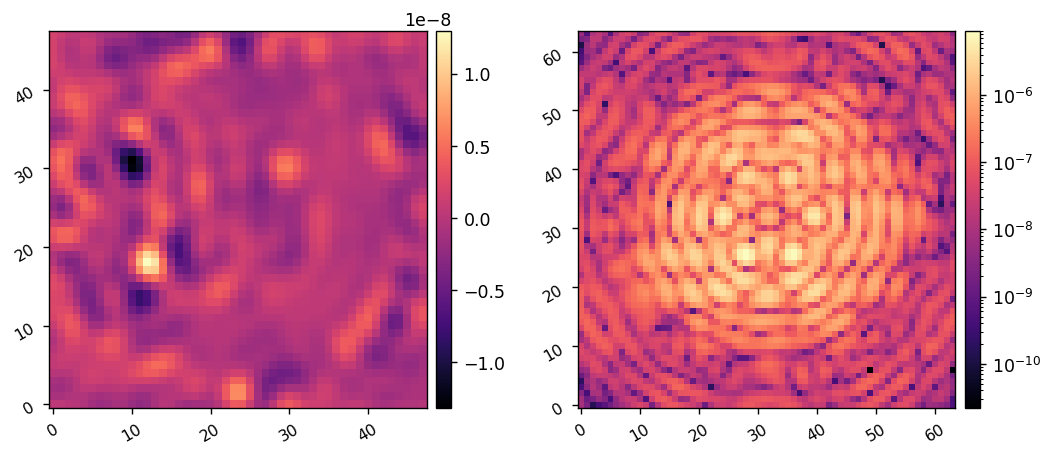

Closed-loop iteration 6 / 10
(2304,) (300,)


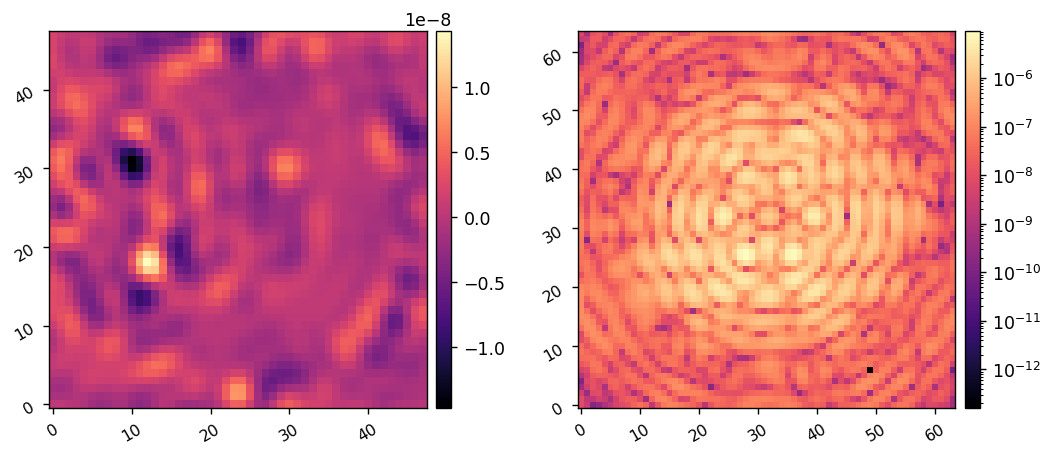

Closed-loop iteration 7 / 10
(2304,) (300,)


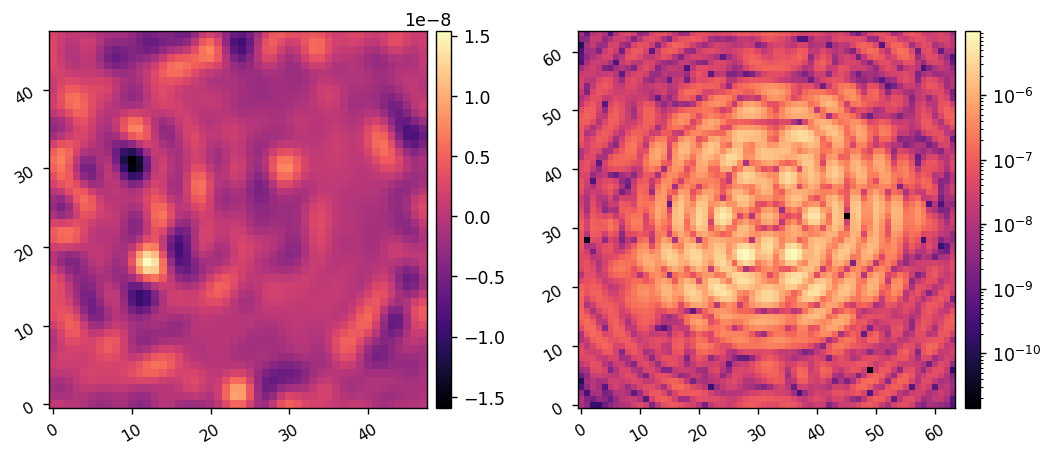

Closed-loop iteration 8 / 10
(2304,) (300,)


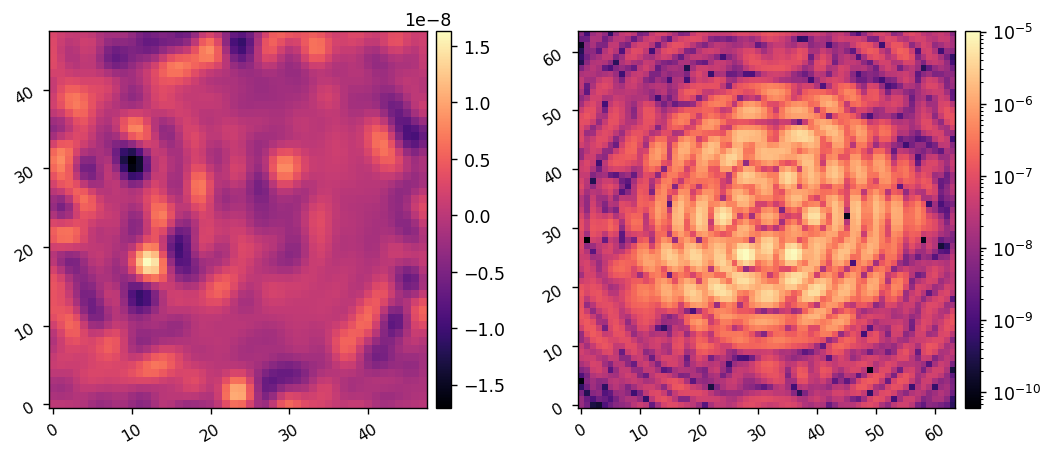

Closed-loop iteration 9 / 10
(2304,) (300,)


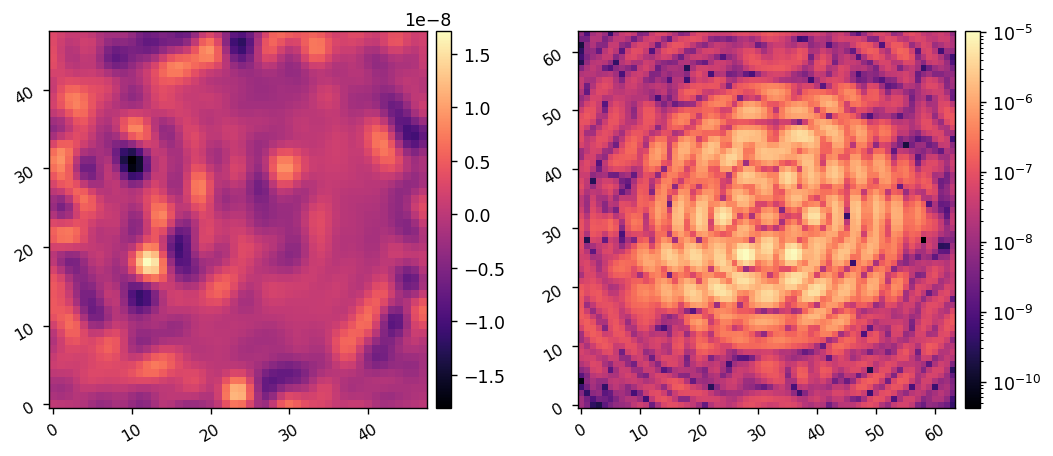

Closed-loop iteration 10 / 10
(2304,) (300,)


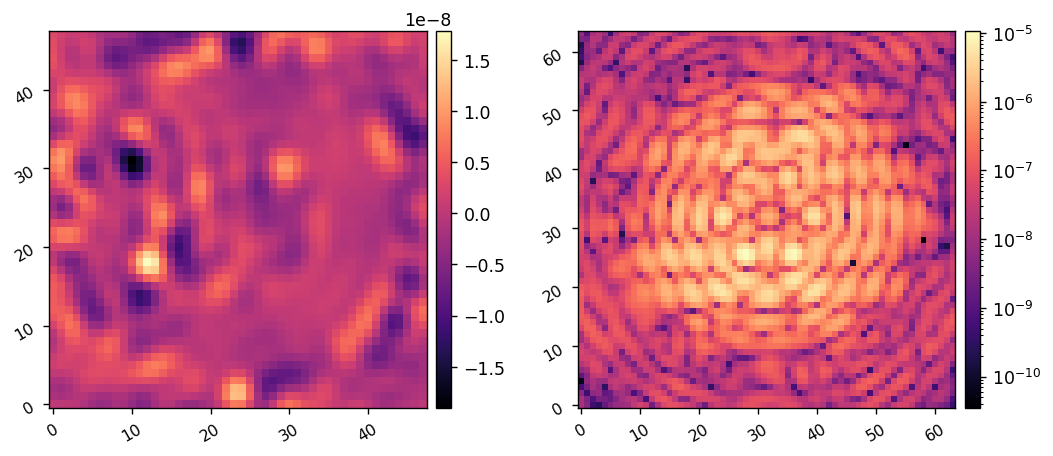

In [15]:
# The metric
metric_images = []
dm_commands = []
command = 0.0

## Run IEFC for num_iterations
num_iterations = 10
gain = -0.4
leakage = 0.0

for i in range(num_iterations):
    print("Closed-loop iteration {:d} / {:d}".format(i+1, num_iterations))
#     delta_coefficients = iefc_functions.IEFC_single_iteration(tbi, probe_modes, probe_amplitude, 
#                                                               control_matrix, weights>0)
    delta_coefficients = iefc.single_iteration(hlci, probe_modes, probe_amplitude, 
                                               control_matrix, weights.flatten()>0)
    command = (1.0-leakage) * command + gain * delta_coefficients
    
    # Reconstruct the full phase from the Fourier modes
    dm_command = np.einsum('ij, i->j', fourier_modes, command)
    print(dm_command.shape, delta_coefficients.shape)
    
    # Set the current DM state
#     tbi.set_dm(dm_command)
#     ret = tbi.send_dm()
    hlci.set_dm1(dm_command)
    
    # Take an image to estimate the metrics
#     metric_images.append(tbi.snap())
    image = hlci.calc_psf()
    metric_images.append(image)
    dm_commands.append(dm_command)
    
    misc.myimshow2(dm_command.reshape(Nact,Nact), image, lognorm2=True)
    pass

In [10]:
hdr = fits.Header()
hdr['GAIN'] = gain
hdr['LEAKAGE'] = leakage

images_hdu = fits.PrimaryHDU(data=metric_images, header=hdr)
images_hdu.writeto(data_dir/'image-results'/'rect_dh.fits', overwrite=True)
dms_hdu = fits.PrimaryHDU(data=dm_commands, header=hdr)
dms_hdu.writeto(data_dir/'dm-results'/'rect_dh.fits', overwrite=True)

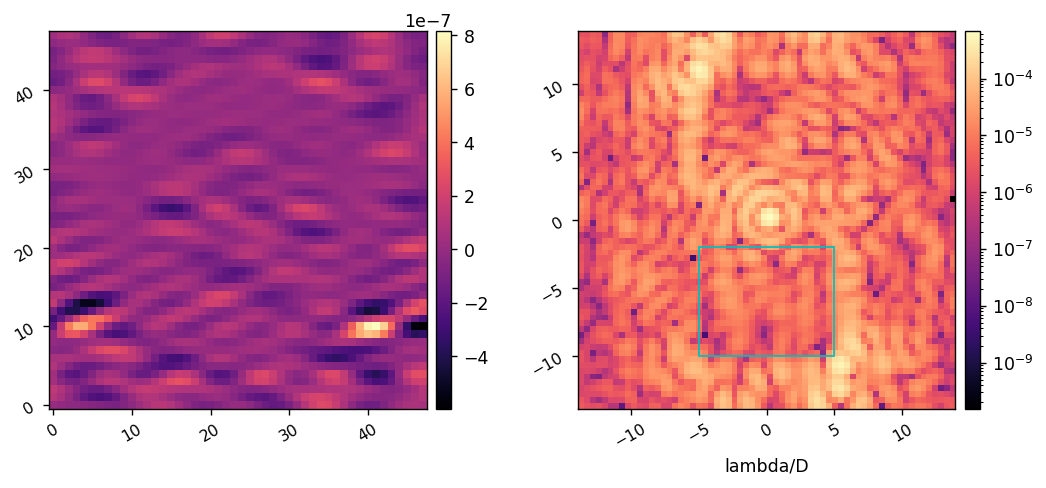

In [17]:
reload(iefc)
ind = 8
patches = [iefc.create_rect_patch(dh_params)]
misc.myimshow2(dm_commands[ind].reshape(Nact,Nact), metric_images[ind], 
               lognorm2=True, patches2=patches, pxscl2=psf_pixelscale_lamD.value)

In [16]:
metric_images = fits.getdata(data_dir/'image-results'/'rect_dh.fits')
dm_commands = fits.getdata(data_dir/'dm-results'/'rect_dh.fits')
hdr = fits.getheader(data_dir/'dm-results'/'rect_dh.fits')
print(hdr['GAIN'], hdr['LEAKAGE'])

-0.4 0.0


# Testing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LogNorm
from matplotlib.animation import FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.ffmpeg_path'] ='/.../bin/ffmpeg.exe'
plt.rcParams['animation.convert_path'] = '/.../magick.exe'
plt.rcParams['animation.html'] = 'html5'

wfs_min, wfs_max = (1, 0)
for i in range(len(images)):
    m, M = ( np.min(images), np.max(images) )
    if m < wfs_min: wfs_min = m
    if M > wfs_max: wfs_max = M

fig,ax = plt.subplots(1,2, figsize=(10,4), dpi=100)

dm_ext = np.array([-Nact/2, Nact/2, -Nact/2, Nact/2])*hlci.act_spacing.value
psf_ext = np.array([-npsf/2, npsf/2, -npsf/2, npsf/2])*psf_pixelscale_lamD
    
ax0 = ax[0].imshow(actuators[0], cmap='magma', extent=dm_ext)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar0 = fig.colorbar(ax0, cax=cax)
ax0_title = ax[0].set_title('Iteration {:d}'.format(range(15)[0]), fontsize = 18)

ax1 = ax[1].imshow(images[0], norm=LogNorm(), cmap='gist_heat', extent=psf_ext)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar0 = fig.colorbar(ax1, cax=cax)
ax1_title = ax[1].set_title('PSF', fontsize = 18)
ax1.add_patch(iefc.create_rect_patch(dh_params))

plt.close()

def animate(i):
    ax0.set_data(actuators[i])
    ax0.set_clim(np.min(actuators[i]), np.max(actuators[i]))
    ax0_title.set_text('Iteration {:d}'.format(range(15)[i]))
    
    ax1.set_data(wavefronts[i][-1].intensity)
    ax1.set_clim(wfs_min, wfs_max)
    ax1.add_patch(iefc.create_rect_patch(dh_params))

anim = animation.FuncAnimation(fig, animate, frames=len(actuators))
anim

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LogNorm
from matplotlib.animation import FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.ffmpeg_path'] ='/.../bin/ffmpeg.exe'
plt.rcParams['animation.convert_path'] = '/.../magick.exe'
plt.rcParams['animation.html'] = 'html5'

wfs_min, wfs_max = (1, 0)
for i in range(len(wavefronts)):
    m, M = ( np.min(wavefronts[i][-1].intensity), np.max(wavefronts[i][-1].intensity) )
    if m < wfs_min: wfs_min = m
    if M > wfs_max: wfs_max = M

fig,ax = plt.subplots(1,2, figsize=(10,4), dpi=100)

dm_ext = np.array([-Nacts/2, Nacts/2, -Nacts/2, Nacts/2])*act_spacing.value
psf_ext = np.array([-npsf/2, npsf/2, -npsf/2, npsf/2])*wavefronts[0][-1].pixelscale.to(u.mm/u.pix).value
    
ax0 = ax[0].imshow(actuators[0], cmap='magma', extent=dm_ext)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar0 = fig.colorbar(ax0, cax=cax)
ax0_title = ax[0].set_title('Iteration {:d}'.format(range(15)[0]), fontsize = 18)

ax1 = ax[1].imshow(wavefronts[0][-1].intensity, norm=LogNorm(), cmap='gist_heat', extent=psf_ext)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar0 = fig.colorbar(ax1, cax=cax)
ax1_title = ax[1].set_title('PSF', fontsize = 18)
plt.close()

def animate(i):
    ax0.set_data(actuators[i])
    ax0.set_clim(np.min(actuators[i]), np.max(actuators[i]))
    ax0_title.set_text('Iteration {:d}'.format(range(15)[i]))
    
    ax1.set_data(wavefronts[i][-1].intensity)
    ax1.set_clim(wfs_min, wfs_max)
    ax1

anim = animation.FuncAnimation(fig, animate, frames=len(actuators))
anim
